In [6]:
import torch
import torch.nn as nn

In [7]:
verbose = False
verboseprint = print if verbose else lambda *a, **k: None

In [8]:
class LinearNet3(nn.Module):
    def __init__(self, in_features = 10):
        super(LinearNet3, self).__init__()
        self.in_features = in_features
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        G_solv = self.linear_relu_stack(x)
        return G_solv

In [9]:
from tqdm import tqdm
def get_accuracy(model, data_loader):
    total_L1, total_L2 = 0, 0
    with torch.no_grad(): # New variables in this block will be created with require_grad = False
        for vector, G_true in tqdm(data_loader):
            G_true = G_true.float()
            output = model(vector)
            L1_loss, L2_loss = nn.L1Loss(), nn.MSELoss()
            L1 = L1_loss(output, G_true)
            L2 = L2_loss(output, G_true)
            total_L1+=L1
            total_L2+=L2
    MAE = total_L1/len(data_loader)
    MSE = total_L2/len(data_loader)
    return MAE, MSE

In [10]:
def solute_3_classes(solute, df):
    row = df.loc[df['SoluteName'] == solute].iloc[0]
    out = torch.tensor((row.Level1, row.Level2, row.Level3))
    return out


# solute_3_classes('hydrogen', df3)
def solute_TESA(solute, df):
    row = df[df['SoluteName'] == solute][:1]
    out = row[row.columns[17:26]]
    out = torch.tensor(out.values, dtype=torch.float)
    # print(f'type TESA: {out.dtype}')
    return out


# solute_TESA('hydrogen', df3)

def solvent_macro_props1(solvent, path_to_table):
    table = pd.read_table(path_to_table)
    row = table[table['Name'] == solvent]
    out = row[row.columns[2:]]
    out = torch.tensor(out.values, dtype=torch.float)
    return out

In [11]:
train_MAE_data, train_MSE_data, val_MAE_data, val_MSE_data = [], [], [], []
def train(model, loss_function, optimizer, epochs = 10):
  # writer = SummaryWriter(comment = tag)
  for epoch in range(epochs):
    hist_loss = 0
    for vector, G_true in train_loader: # get batch
        # print(f'v = {vector.shape}')
        # print(vector)
        G_true = G_true.float()
        outputs = model(vector) # call forward inside

        verboseprint(f'out: {outputs.size()}')

        loss = loss_function(outputs, G_true) # calculate loss
        loss.backward() # calculate gradients
        optimizer.step() # performs a single optimization step (parameter update).
        optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.

        hist_loss += loss.item() # For stat only

    print(f'Epoch {epoch} -> train loss: {hist_loss / ( len(train_loader) )}')
    train_MAE, train_MSE = get_accuracy(model, train_loader)
    val_MAE, val_MSE = get_accuracy(model, val_loader)
    train_MAE_data.append(train_MAE)
    train_MSE_data.append(train_MSE)
    val_MAE_data.append(val_MAE)
    val_MSE_data.append(val_MSE)

  MAE, MSE = get_accuracy(model, val_loader)
  return MAE, MSE

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Deleting charges species
filename = r'/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/MNSol-v2009_energies_v2.tsv'
with open(filename) as f:
    t = 0
    data = pd.read_table(f)
    df1 = pd.DataFrame(data)

df2 = df1.loc[df1['Charge'].isin([0])]

# Deleting solvent mixtures
filename2 = r'/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/MNSolDatabase_v2012/Solvent_properties.tsv'
with open(filename2) as f:
    data = pd.read_table(f, header=1)
    solvent_props = pd.DataFrame(data)
names = []
for name, count in df2['Solvent'].value_counts().items():
    row = solvent_props.loc[solvent_props['Name'] == name]
    values = np.array(row[['nD', 'alpha', 'beta', 'gamma', 'epsilon', 'phi', 'psi']])
    # print(f'{name} -> {count} -> {values.shape[0]}')
    if values.shape[0] == 0:
        print(name)
        names.append(name)
df3 = df2.loc[~df2['Solvent'].isin(names)]

## Creating table solvent - solute
Solvents = dict(df3['Solvent'].value_counts().items())

Solutes = dict(df3['SoluteName'].value_counts().items())
from collections import OrderedDict

Solvents = OrderedDict(df3['Solvent'].value_counts().items())
Solutes = OrderedDict(df3['SoluteName'].value_counts().items())
table_SS = pd.DataFrame(index=Solutes, columns=Solvents)

# testa = df3.loc[df3['Solvent'] == 'water'].loc[df3['SoluteName'] == 'hydrogen']['DeltaGsolv']
# testa
# if testa.empty:
#     print(1)
# else:
#     print(0)

for solute in Solutes:
    for solvent in Solvents:
        SS_row = df3.loc[df3['Solvent'] == solvent].loc[df3['SoluteName'] == solute]['DeltaGsolv']
        if SS_row.empty:
            pass
        else:
            table_SS[solvent][solute] = SS_row.item()

table_SS.to_csv('/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/Dataset preparation/table_SS.csv')

# table_SS.head()
table_SS.columns.tolist()
table_SS.index.tolist()
for solvent in table_SS.columns.tolist():
    for solute in table_SS.index.tolist():
        G_solv = table_SS[solvent][solute]
        if not pd.isna(G_solv):
            print(f's:{solvent} - {solute}: {G_solv}')
        else:
            print(f'NaN:{solvent} - {solute}: {G_solv}')


def test_sp(solvent):
    return torch.tensor(len(solvent))


def test_up(solute):
    return torch.tensor(len(solute))


## Creating SS Dataset
from torch.utils.data import Dataset


class SS_Dataset(Dataset):
    def __init__(self, table, solvent_props, solute_props, args = ((), ()), transform=None):
        self.table = table
        self.solvent_props = solvent_props
        self.solute_props = solute_props
        self.data = []
        self.transform = transform
        self.table = self.table.set_index('Unnamed: 0')
        self.sp, self.up = args
        for solvent in self.table.columns.tolist():
            for solute in self.table.index.tolist():
                G_solv = self.table[solvent][solute]
                if not pd.isna(G_solv):
                    self.data.append((solvent, solute, G_solv))

    def __getitem__(self, i):
        solvent, solute, G_solv = self.data[i]
        X1 = self.solvent_props(solvent, self.sp)
        X2 = self.solute_props(solute, self.up)
        #check dim
        # print(f'X1 - {X1.shape}')
        # print(f'X2 - {X2.shape}')
        verboseprint(f'X1 {X1.dtype}]')
        verboseprint(f'X2 {X2.dtype}]')
        X = torch.cat((X1, X2), 1)
        y = G_solv
        return X, y

    def __len__(self):
        return len(self.data)


table_v1 = pd.read_csv(
    '/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/Dataset preparation/table_SS_v1/table_SS_v1.csv')
# table_v1.head()

# table_v1.shape

from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

table_v1 = pd.read_csv(
    '/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/Dataset preparation/table_SS_v1/table_SS_v1.csv')
path_props = '/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/MNSolDatabase_v2012/Solvent_properties1.tsv'
TESA_df = df3
args = (path_props, TESA_df)
dataset = SS_Dataset(table_v1, solvent_macro_props1, solute_TESA, args)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len_data - val_data, val_data])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Creating vectorizers for solute and solvent
# df3.head()





# solvent_macro_props1('anisole',
#                      '/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/MNSolDatabase_v2012/Solvent_properties1.tsv')



octanol-water
diethylether-water
chloroform-water
heptane-water
isopropyltoluene
cyclohexane-water
benzene-water
ethylacetate-water
dichloroethane-water
carbontet-water
hexane-water
butanol-water
dibutylether-water
chlorobenzene-water
dibromoethane-water
nitrobenzene-water
s:water - ethanol: -5.01
NaN:water - toluene: nan
s:water - 2-butanone: -3.64
s:water - n-octane: 2.89
s:water - nitromethane: -3.95
s:water - 1,4-dioxane: -5.05
s:water - phenol: -6.62
s:water - acetic acid: -6.7
s:water - ethyl acetate: -3.1
s:water - butyl acetate: -2.55
s:water - propanoic acid: -6.47
s:water - methyl acetate: -3.32
s:water - 1-hexanol: -4.36
s:water - 1-propanol: -4.83
s:water - 1-butanol: -4.72
s:water - 1-pentanol: -4.47
s:water - butylamine: -4.29
s:water - propyl acetate: -2.86
s:water - methanol: -5.11
s:water - 1-heptanol: -4.24
s:water - ethylamine: -4.5
s:water - propylamine: -4.39
s:water - methyl pentanoate: -2.57
s:water - methyl propanoate: -2.93
s:water - p-cresol: -6.14
s:water - p

(401, 90)

In [225]:
in_feat = next(iter(dataset))[0].shape[-1]
verbose = False
model = LinearNet3(in_features = in_feat)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

MAE, MSE = train(model, loss_function, optimizer, epochs=30)

Epoch 0 -> train loss: 8.026403942108153


  0%|          | 0/25 [00:00<?, ?it/s]/Users/balepka/PycharmProjects/msuAI/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 96%|█████████▌| 24/25 [00:02<00:00, 11.78it/s]/Users/balepka/PycharmProjects/msuAI/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 11/11 [00:00<00:00, 53.12it/s]


Epoch 1 -> train loss: 4.399695644378662


100%|██████████| 11/11 [00:00<00:00, 44.08it/s]


Epoch 2 -> train loss: 4.064428129196167


100%|██████████| 11/11 [00:00<00:00, 53.15it/s]


Epoch 3 -> train loss: 3.879323196411133


100%|██████████| 11/11 [00:00<00:00, 54.22it/s]


Epoch 4 -> train loss: 3.7946047401428222


100%|██████████| 11/11 [00:00<00:00, 50.03it/s]


Epoch 5 -> train loss: 3.8112222003936767


100%|██████████| 11/11 [00:00<00:00, 52.59it/s]


Epoch 6 -> train loss: 3.7545580291748046


100%|██████████| 11/11 [00:00<00:00, 45.58it/s]


Epoch 7 -> train loss: 3.6772912979125976


100%|██████████| 11/11 [00:00<00:00, 48.41it/s]


Epoch 8 -> train loss: 3.7339073181152345


100%|██████████| 11/11 [00:00<00:00, 50.02it/s]


Epoch 9 -> train loss: 3.715476007461548


100%|██████████| 11/11 [00:00<00:00, 55.30it/s]


Epoch 10 -> train loss: 3.6432244396209716


100%|██████████| 11/11 [00:00<00:00, 48.38it/s]


Epoch 11 -> train loss: 3.6265188217163087


100%|██████████| 11/11 [00:00<00:00, 46.29it/s]


Epoch 12 -> train loss: 3.5948758220672605


100%|██████████| 11/11 [00:00<00:00, 47.58it/s]


Epoch 13 -> train loss: 3.605041799545288


100%|██████████| 11/11 [00:00<00:00, 48.39it/s]


Epoch 14 -> train loss: 3.600987014770508


100%|██████████| 11/11 [00:00<00:00, 55.05it/s]


Epoch 15 -> train loss: 3.6108282470703124


100%|██████████| 11/11 [00:00<00:00, 51.43it/s]


Epoch 16 -> train loss: 3.5736422538757324


100%|██████████| 11/11 [00:00<00:00, 53.71it/s]


Epoch 17 -> train loss: 3.542581205368042


100%|██████████| 11/11 [00:00<00:00, 49.44it/s]


Epoch 18 -> train loss: 3.497520990371704


100%|██████████| 11/11 [00:00<00:00, 39.12it/s]


Epoch 19 -> train loss: 3.463968858718872


100%|██████████| 11/11 [00:00<00:00, 46.02it/s]


Epoch 20 -> train loss: 3.5623740673065187


100%|██████████| 11/11 [00:00<00:00, 42.60it/s]


Epoch 21 -> train loss: 3.5030234718322752


100%|██████████| 11/11 [00:00<00:00, 49.09it/s]


Epoch 22 -> train loss: 3.4695928287506104


100%|██████████| 11/11 [00:00<00:00, 46.84it/s]


Epoch 23 -> train loss: 3.5622223377227784


100%|██████████| 11/11 [00:00<00:00, 52.01it/s]


Epoch 24 -> train loss: 3.6269331645965575


100%|██████████| 11/11 [00:00<00:00, 42.37it/s]


Epoch 25 -> train loss: 3.57019681930542


100%|██████████| 11/11 [00:00<00:00, 46.29it/s]


Epoch 26 -> train loss: 3.5268405151367186


100%|██████████| 11/11 [00:00<00:00, 50.72it/s]


Epoch 27 -> train loss: 3.5954073667526245


100%|██████████| 11/11 [00:00<00:00, 52.15it/s]


Epoch 28 -> train loss: 3.586486568450928


100%|██████████| 11/11 [00:00<00:00, 53.08it/s]


Epoch 29 -> train loss: 3.568144760131836


100%|██████████| 11/11 [00:00<00:00, 47.36it/s]


In [13]:
Solvents

OrderedDict([('water', 345),
             ('octanol', 206),
             ('hexadecane', 190),
             ('chloroform', 105),
             ('cyclohexane', 91),
             ('carbontet', 78),
             ('benzene', 75),
             ('diethylether', 67),
             ('heptane', 66),
             ('hexane', 59),
             ('toluene', 51),
             ('xylene', 48),
             ('decane', 39),
             ('dichloroethane', 39),
             ('octane', 38),
             ('chlorobenzene', 38),
             ('isooctane', 32),
             ('ethylbenzene', 29),
             ('bromobenzene', 27),
             ('pentane', 26),
             ('decalin', 26),
             ('nonane', 26),
             ('pentanol', 22),
             ('diisopropylether', 22),
             ('butylacetate', 22),
             ('ethylacetate', 21),
             ('butanol', 20),
             ('iodobenzene', 20),
             ('isopropylbenzene', 19),
             ('isobutanol', 17),
             ('tributylph

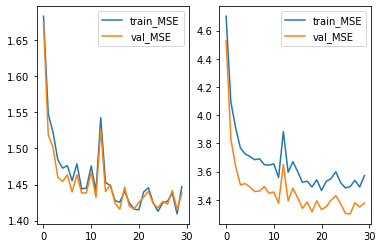

In [233]:
from matplotlib import pyplot as plt
epoch_numbers = range(30)
plt.subplot(121)
plt.plot(epoch_numbers, train_MAE_data)
plt.plot(epoch_numbers, val_MAE_data)
plt.legend(['train_MSE', 'val_MSE'])
plt.subplot(122)
plt.plot(epoch_numbers, train_MSE_data)
plt.plot(epoch_numbers, val_MSE_data)
plt.legend(['train_MSE', 'val_MSE'])

In [209]:
print(f'MAE: {MAE}, MSE: {MSE}')

MAE: 1.4371072053909302, MSE: 3.46443772315979


10: MAE: 1.4371072053909302, MSE: 3.46443772315979
20: MAE: 1.4250857830047607, MSE: 3.3329851627349854
30: MAE: 1.4553229808807373, MSE: 3.6278512477874756

In [211]:
MAE, MSE = train(model, loss_function, optimizer)
print(f'MAE: {MAE}, MSE: {MSE}')

Epoch 0 -> train loss: 3.681610884666443
Epoch 1 -> train loss: 3.7685911369323732
Epoch 2 -> train loss: 3.5768763065338134
Epoch 3 -> train loss: 3.5610460948944094
Epoch 4 -> train loss: 3.626980333328247
Epoch 5 -> train loss: 3.558011226654053
Epoch 6 -> train loss: 3.5031476497650145
Epoch 7 -> train loss: 3.5137485313415526
Epoch 8 -> train loss: 3.533503851890564
Epoch 9 -> train loss: 3.7024927043914797


100%|██████████| 11/11 [00:00<00:00, 52.19it/s]

MAE: 1.4553229808807373, MSE: 3.6278512477874756


In [ ]:
# dataset = SS_Dataset(table_v1, solvent_macro_props1, solute_TESA)
# len_data = dataset.__len__()
# val_data = len_data // 10
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len_data - val_data, val_data])
#
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [52]:
# ttable = table_v1.set_index('Unnamed: 0')

In [58]:
# ttable.index.tolist()

['ethanol',
 'toluene',
 '2-butanone',
 'n-octane',
 'nitromethane',
 '1,4-dioxane',
 'phenol',
 'acetic acid',
 'ethyl acetate',
 'butyl acetate',
 'propanoic acid',
 'methyl acetate',
 '1-hexanol',
 '1-propanol',
 '1-butanol',
 '1-pentanol',
 'butylamine',
 'propyl acetate',
 'methanol',
 '1-heptanol',
 'ethylamine',
 'propylamine',
 'methyl pentanoate',
 'methyl propanoate',
 'p-cresol',
 'pentyl acetate',
 'o-cresol',
 'p-bromophenol',
 'aniline',
 '2-hexanone',
 '2-pentanone',
 '2-heptanone',
 'butanoic acid',
 '3,3-dimethylbutanone',
 'acetone',
 'methyl hexanoate',
 'benzene',
 'pyridine',
 'm-cresol',
 'water',
 'diethylamine',
 'hydrogen peroxide',
 'pentanoic acid',
 'hexanoic acid',
 '4-methylaniline',
 'ethylbenzene',
 'trimethylamine',
 'chlorobenzene',
 'acetophenone',
 'methylamine',
 'nitrobenzene',
 'bromobenzene',
 'naphthalene',
 'fluorobenzene',
 'benzamide',
 'benzaldehyde',
 'benzonitrile',
 'formaldehyde',
 'ammonia',
 'methyl benzoate',
 'dimethylamine',
 'p-hyd

In [40]:
# table_v1.reindex()

,Unnamed: 0,water,octanol,hexadecane,chloroform,cyclohexane,carbontet,benzene,diethylether,heptane,...,benzonitrile,nitroethane,mcresol,dimethylformamide,dimethylacetamide,bromoethane,fluorobenzene,methylformamide,aceticacid,tetrahydrofuran
0,ethanol,-5.01,-4.36,-2.03,-3.94,-2.42,-2.96,-3.42,-4.41,-2.15,...,-4.05,-3.98,-5.58,-5.23,-5.40,NaN,-3.45,-5.12,-5.25,-4.56
1,toluene,NaN,-4.55,-4.54,-5.48,-4.90,-5.12,-5.32,-5.23,-4.78,...,-4.95,-4.88,-4.58,-4.88,-4.94,-5.55,-5.27,-4.34,-4.53,-5.50
2,2-butanone,-3.64,-3.78,-3.12,-5.43,-3.48,-4.09,-4.46,-4.09,-3.36,...,-4.58,-4.73,-5.98,-4.56,-4.52,-5.13,-4.60,-4.34,-4.80,-4.54
3,n-octane,2.89,-4.18,-5.02,-5.25,-5.63,-5.39,-5.35,-5.62,NaN,...,-4.34,-3.89,-4.02,-3.77,-3.94,-5.54,-4.99,-3.34,-3.93,-5.39
4,nitromethane,-3.95,-3.51,-2.58,-4.68,-2.86,-3.52,-4.50,-4.19,NaN,...,-5.05,-5.35,-4.73,-5.66,-5.62,-4.54,-4.62,-5.11,-4.88,-5.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,"1,2-dichlorobenzene",-1.36,-6.01,-6.16,NaN,NaN,NaN,NaN,NaN,-6.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,thioanisole,-2.73,-6.47,NaN,-5.98,-5.66,-5.66,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,trichloroethene,-0.39,-3.75,-4.08,NaN,-4.29,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,4-methylpyridine,-4.94,-6.60,-4.89,-7.50,-5.23,NaN,-6.17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
testa = torch.ones((2,3))

In [142]:
testa.dtype

torch.float32

In [236]:
val_loader.dataset[0]

(tensor([[ 1.4684,  0.0000,  0.1000, 38.3700,  5.4200,  0.8570,  0.1430, 64.2220,
          61.5130, 43.3610, 82.4010,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]),
 -4.6)

In [234]:
for vector, G_true in val_loader:
    print(vector)

tensor([[[1.4684e+00, 0.0000e+00, 1.0000e-01, 3.8370e+01, 5.4200e+00,
          8.5700e-01, 1.4300e-01, 6.4222e+01, 6.1513e+01, 4.3361e+01,
          8.2401e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]],

        [[1.3974e+00, 0.0000e+00, 0.0000e+00, 3.0430e+01, 1.9406e+00,
          0.0000e+00, 0.0000e+00, 8.9122e+01, 1.4130e+01, 4.2372e+01,
          8.5700e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]],

        [[1.3679e+00, 0.0000e+00, 4.1000e-01, 2.4860e+01, 3.3800e+00,
          0.0000e+00, 0.0000e+00, 2.7894e+01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 4.4588e+01, 1.9698e+01, 0.0000e+00,
          0.0000e+00]],

        [[1.5011e+00, 0.0000e+00, 1.4000e-01, 4.0620e+01, 2.2706e+00,
          1.0000e+00, 0.0000e+00, 1.6443e+02, 2.5524e+01, 1.0168e+02,
          2.2829e+01, 0.0000e+00, 1.9305e+01, 8.9400e+00, 0.0000e+00,
          0.0000e+00]],

        [[1.3941e+00, 0.0000e+00, 4.5000e-01, 3.5810e+01, 4.

In [222]:
print(model)

LinearNet3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [14]:
from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

identifiers  = ['3-Methylheptane', 'Aspirin', 'Diethylsulfate', 'Diethyl sulfate', '50-78-2', 'Adamant']

for ids in identifiers :
    print(ids, CIRconvert(ids))

3-Methylheptane CCCCC(C)CC
Aspirin CC(=O)Oc1ccccc1C(O)=O
Diethylsulfate CCO[S](=O)(=O)OCC
Diethyl sulfate CCO[S](=O)(=O)OCC
50-78-2 CC(=O)Oc1ccccc1C(O)=O
Adamant Did not work


In [240]:
Solvents


OrderedDict([('water', 345),
             ('octanol', 206),
             ('hexadecane', 190),
             ('chloroform', 105),
             ('cyclohexane', 91),
             ('carbontet', 78),
             ('benzene', 75),
             ('diethylether', 67),
             ('heptane', 66),
             ('hexane', 59),
             ('toluene', 51),
             ('xylene', 48),
             ('decane', 39),
             ('dichloroethane', 39),
             ('octane', 38),
             ('chlorobenzene', 38),
             ('isooctane', 32),
             ('ethylbenzene', 29),
             ('bromobenzene', 27),
             ('pentane', 26),
             ('decalin', 26),
             ('nonane', 26),
             ('pentanol', 22),
             ('diisopropylether', 22),
             ('butylacetate', 22),
             ('ethylacetate', 21),
             ('butanol', 20),
             ('iodobenzene', 20),
             ('isopropylbenzene', 19),
             ('isobutanol', 17),
             ('tributylph

In [15]:
file = '/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/Tables/SMILES_solvents.txt'
with open(file, 'w') as f:
    for i, solvent in enumerate(Solvents):
        smiles = CIRconvert(solvent)
        # print(f'{solvent} -> {smiles}')
        f.write(f'{i}\t{solvent}\t{smiles}\n')


In [ ]:
file = '/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/Tables/SMILES_solutes.txt'
with open(file, 'w') as f:
    for i, solute in enumerate(Solutes):
        smiles = CIRconvert(solute)
        # print(f'{solute} -> {smiles}')
        f.write(f'{i}\t{solute}\t{smiles}\n')

In [260]:
len(Solutes)

402

In [16]:
len(Solvents)

90

In [3]:
import torch
import torchani
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True


def get_smiles(compound):
    #TODO make smiles work
    smiles = CIRconvert(compound)
    return smiles
def visualize(solvent, solute, model):
    mol = Chem.MolFromSmiles(get_smiles(solvent))


ModuleNotFoundError: No module named 'rdkit'

In [ ]:
mol = Chem.MolFromSmiles(smiles)